In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
# from unidecode import unidecode # For replacing non-english characters
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import re
from collections import Counter
import networkx as nx # For graph visualization

In [78]:
pd.set_option('display.max_rows', None)

# Step 1: Read and display the script and character data

In [107]:
characters_df = pd.read_csv('../Data/lotr/lotr_characters.csv')
scripts_df = pd.read_csv('../Data/lotr/lotr_scripts.csv')

                            

In [108]:
scripts_df.head(2)

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King


In [109]:
scripts_df.shape

(2390, 4)

In [110]:
characters_df.head(2)

,birth,death,gender,hair,height,name,race,realm,spouse
0,NaN,NaN,Female,NaN,NaN,Adanel,Men,NaN,Belemir
1,TA 2978,"February 26 ,3019",Male,Dark (book) Light brown (movie),NaN,Boromir,Men,NaN,NaN


In [111]:
characters_df.shape

(911, 9)

# Step 2: We will start with editing scripts_df

In [112]:
scripts_df.drop('Unnamed: 0', inplace=True, axis=1) #Remove dummy first column

In [113]:
scripts_df.describe() # Describe the dataframe

,char,dialog,movie
count,2390,2389,2390
unique,118,2325,3
top,FRODO,DEATH!,The Two Towers
freq,225,6,1010


In [114]:
scripts_df.dtypes # Look at the types. We notice that they are all object so need to convert to string

char      object
dialog    object
movie     object
dtype: object

In [115]:
# Utility function to get character classes
def get_char_classes(df, field):
    print(f"We have {len(df[field].unique())} characters as follows for Lord of The Rings:\n {df[field].unique()}")
        

In [116]:
get_char_classes(scripts_df, 'char')

We have 118 characters as follows for Lord of The Rings:
 ['DEAGOL' 'SMEAGOL' '(GOLLUM' 'FRODO' 'MERRY' 'GIMLI' 'GOLLUM' 'SAM'
 'GANDALF' 'ARAGORN' 'PIPPIN' 'HOBBIT' 'ROSIE' 'BILBO' 'TREEBEARD'
 'SARUMAN' 'THEODEN' 'GALADRIL' 'ELROND' 'GRIMA' 'FRODO VOICE OVER'
 'WITCH KING' 'EOWYN' 'FARAMIR' 'ORC' '\xa0GANDALF' 'SOLDIERS ON GATE'
 'GOTHMOG' 'GENERAL' 'CAPTAIN' 'SOLDIER' 'MOUTH OF SAURON' 'EOMER' 'ARMY'
 'BOSON' 'MERCENARY' 'EOWYN/MERRY' 'DENETHOR' 'ROHIRRIM'
 'GALADRIEL VOICEOVER' 'LEGOLAS' 'GALADRIEL' 'KING OF THE DEAD' 'GRIMBOLD'
 'IROLAS' 'ORCS' 'GAMLING' 'MADRIL' 'DAMROD' 'SOLDIERS'
 'SOLDIERS IN MINAS TIRITH' 'GANDALF VOICEOVER' 'SOLDIER 1' 'SOLDIER 2'
 'WOMAN' 'HALDIR' 'SAM VOICEOVER' 'OLD MAN' 'BOROMIR' 'CROWD' 'ARWEN'
 'ELROND VOICEOVER' 'ARWEN VOICEOVER' 'ARAGORN ' 'HAMA' 'SHARKU' 'PEOPLE'
 'LADY' 'FREDA' 'MORWEN' 'EYE OF SAURON' 'ROHAN STABLEMAN' 'GORBAG'
 'ARGORN' 'GANDALF VOICE OVER' 'BOROMIR ' 'UGLUK' 'SHAGRAT'
 'SARUMAN VOICE OVER' 'SARUMAN VOICE OVER ' 'FRODO ' 'URUK-HA

We see several problems:
0. Upercase all characters
1. '(GOLLUM' has punctuation so need to remove that
2. There are some garbage characters trailing and leading
3. Whenever, VOICE OVER is a suffix, that is the same as the actual character speaking for our purposes
4. Some character names are mispelled such as GRISHNAKH is spelled in two different ways and others like STRIDER and ARAGORN are the same person
5. (optional): remove all white-space. This is a last reserve
Solution: we will apply each transformation separately and observe the results

In [117]:
def remove_voice(character):
    if character == 'VOICE':
        character = 'NARRATOR'
    character = character.replace('VOICEOVER', '')
    character = character.replace('VOICE OVER', '')
    character = character.replace('VOICE', '')
    character = character.strip()
    return character

In [118]:
def fix_spelling(character):
    if character == 'STRIDER':
        character = 'ARAGORN'
    if 'GAN' in character and 'DALF' in character:
        character = 'GANDALF'
    if 'SOLDIER' in character:
        character = 'SOLDIER'
    if 'GRISHNAK' in character:
        character = 'GRICKNAK'
    if 'URUK' in character:
        character = 'URUKHAI'
    if 'GATEKEEP' in character:
        character = 'GATEKEEPER'
    if 'ORC' in character:
        character = 'ORC'
    if 'GALAD' in character:
        character = 'GALADRIEL'
    return character
    

In [119]:
def clean_dialog(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text



In [120]:
def clean_df(df, field):
    df = df.astype(str)
    if field == 'char':
        
        df[field] = df[field].str.strip()
        df[field] = df[field].str.upper()
        #1. Remove punctuation
        df[field] = scripts_df[field].str.replace('[{}]'.format(string.punctuation), '')
        #2.Remove trailing and leading garbage characters
        df[field] = df[field].str.strip()
        #3. Remove voice
        df[field] = df[field].apply(remove_voice)
        #4. Fix spelling
        df[field] = df[field].apply(fix_spelling)
    
    elif field == 'movie':
        
        df[field] = df[field].str.strip()
        df[field] = df[field].str.upper()
    
    elif field == 'dialog':
        
        df[field] = df[field].apply(clean_dialog)
        
        
        
        
        
        
    return df

In [121]:
scripts_df = clean_df(scripts_df, 'char')

In [122]:
get_char_classes(scripts_df, 'char')

We have 85 characters as follows for Lord of The Rings:
 ['DEAGOL' 'SMEAGOL' 'GOLLUM' 'FRODO' 'MERRY' 'GIMLI' 'SAM' 'GANDALF'
 'ARAGORN' 'PIPPIN' 'HOBBIT' 'ROSIE' 'BILBO' 'TREEBEARD' 'SARUMAN'
 'THEODEN' 'GALADRIEL' 'ELROND' 'GRIMA' 'WITCH KING' 'EOWYN' 'FARAMIR'
 'ORC' 'SOLDIER' 'GOTHMOG' 'GENERAL' 'CAPTAIN' 'MOUTH OF SAURON' 'EOMER'
 'ARMY' 'BOSON' 'MERCENARY' 'EOWYNMERRY' 'DENETHOR' 'ROHIRRIM' 'LEGOLAS'
 'KING OF THE DEAD' 'GRIMBOLD' 'IROLAS' 'GAMLING' 'MADRIL' 'DAMROD'
 'WOMAN' 'HALDIR' 'OLD MAN' 'BOROMIR' 'CROWD' 'ARWEN' 'HAMA' 'SHARKU'
 'PEOPLE' 'LADY' 'FREDA' 'MORWEN' 'EYE OF SAURON' 'ROHAN STABLEMAN'
 'GORBAG' 'ARGORN' 'UGLUK' 'SHAGRAT' 'URUKHAI' 'SNAGA' 'GRICKNAK'
 'MERRY and PIPPIN' 'WILDMAN' 'EOTHAIN' 'ROHAN HORSEMAN' 'SAURON'
 'FARMER MAGGOT' 'WHITE WIZARD' 'MERRY AND PIPPIN' 'GAFFER' 'NOAKES'
 'SANDYMAN' 'FIGWIT' 'GENERAL SHOUT' 'MRS BRACEGIRDLE' 'PROUDFOOT HOBBIT'
 'GATEKEEPER' 'MAN' 'CHILDREN HOBBITS' 'BARLIMAN' 'RING' 'MEN' 'NARRATOR']


In [123]:
scripts_df.char.value_counts()

FRODO               229
SAM                 218
GANDALF             215
ARAGORN             212
PIPPIN              163
MERRY               137
GOLLUM              134
GIMLI               116
THEODEN             110
FARAMIR              65
EOWYN                56
LEGOLAS              55
SMEAGOL              49
BILBO                48
TREEBEARD            46
DENETHOR             45
BOROMIR              41
SOLDIER              41
SARUMAN              41
ARWEN                40
EOMER                36
ELROND               31
ORC                  25
GRIMA                25
GALADRIEL            19
GAMLING              15
GOTHMOG              14
UGLUK                 9
SHAGRAT               9
WITCH KING            8
KING OF THE DEAD      8
HALDIR                7
MADRIL                7
HAMA                  6
URUKHAI               6
MOUTH OF SAURON       5
MORWEN                5
GRICKNAK              5
BARLIMAN              4
GORBAG                3
WILDMAN               3
MERRY and PIPPIN

In [124]:
# Extract the top 10 characters by lines
top10_chars_allmovies = scripts_df.char.value_counts().index.tolist()[:10]

In [125]:
top10_chars_allmovies

['FRODO',
 'SAM',
 'GANDALF',
 'ARAGORN',
 'PIPPIN',
 'MERRY',
 'GOLLUM',
 'GIMLI',
 'THEODEN',
 'FARAMIR']

*Based on the character value counts, it appears that Frodo and Sam have the most lines in all the movies and in general, the top 4 characters have the most lines in all the movies*<br>

*Based on this scripts value counts, most of the lines are unique*

In [126]:
scripts_df.movie.value_counts()

The Two Towers                 1010
The Return of the King          873
The Fellowship of the Ring      507
Name: movie, dtype: int64

*Based on the movie value counts, the second movie "The Two Towers" has the most dialogue.*

In [127]:
scripts_df.movie.unique()

array(['The Return of the King ', 'The Two Towers ',
       'The Fellowship of the Ring '], dtype=object)

In [128]:
scripts_df = clean_df(scripts_df, 'movie')

*We now start preprocessing the actual dialog data*

In [129]:
scripts_df[['dialog']]

,dialog
0,"Oh Smeagol Ive got one! , Ive got a fish Smeag..."
1,"Pull it in! Go on, go on, go on, pull it in!"
2,Arrghh!
3,Deagol!
4,Deagol!
5,Deagol!
6,Give us that! Deagol my love
7,Why?
8,"Because' , it's my birthday and I wants it."
9,My precious.


In [130]:
len(scripts_df.dialog.unique())

2326

In [131]:
scripts_df = clean_df(scripts_df, 'dialog')

In [132]:
scripts_df['corpus_dialog'] = scripts_df.dialog.apply(lambda x: Counter(x.split()))

In [133]:
scripts_df[['corpus_dialog']]

,corpus_dialog
0,"{'oh': 1, 'smeagol': 3, 'ive': 2, 'got': 2, 'o..."
1,"{'pull': 2, 'go': 3}"
2,{'arrghh': 1}
3,{'deagol': 1}
4,{'deagol': 1}
5,{'deagol': 1}
6,"{'give': 1, 'us': 1, 'deagol': 1, 'love': 1}"
7,{}
8,"{'birthday': 1, 'wants': 1}"
9,{'precious': 1}


# Visualizations

In [145]:
class GraphVisualization:
    
    def __init__(self, char_vocab):
        self.char_vocab = char_vocab
        self.visual = []
        self.visualize()
    
    def add_edge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
        
    def visualize(self):
        G = nx.Graph()
        
        marked = {} #Set to view marked characters
        for char in char_vocab:
            word = char_vocab[char]
            marked.add(char)

            if word != char and word in char_vocab and word not in marked:
                #Make a link between two distinct characters if they do not refer to themselves
                self.add_edge(char, word)
                marked.add(word)
        
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
    
    

In [180]:
class GraphVisualization:
    
    def __init__(self):
        self.visual = []
    
    def add_edge(self, a, b):
        print(f"a:{a} and b:{b}")
        temp = (a, b)
        
        self.visual.append(temp)
        print("hey yo")
        
    def visualize(self):
        G = nx.Graph()        
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
    
    

# Step 3: Now we will look at the vocabulary of each character over the course of the movies to see any transformations such as growth/regression

In [375]:
fellowship_df = scripts_df[scripts_df.movie=='THE RETURN OF THE KING']
two_towers_df = scripts_df[scripts_df.movie=='THE TWO TOWERS']
return_king_df = scripts_df[scripts_df.movie=='THE FELLOWSHIP OF THE RING']

In [46]:
two_towers_df.groupby('char')['dialog'].count().reset_index(name='obs').sort_values(['obs'], ascending=False).head(10)

,char,obs
0,ARAGORN,99
34,SAM,89
12,FRODO,84
17,GOLLUM,78
40,THEODEN,64
16,GIMLI,58
31,PIPPIN,56
25,MERRY,55
15,GANDALF,47
41,TREEBEARD,43


In [47]:
return_king_df.groupby('char').size().reset_index(name='obs').sort_values(['obs'], ascending=False).head(10)

,char,obs
12,GANDALF,73
9,FRODO,71
0,ARAGORN,52
3,BILBO,43
21,MERRY,41
27,PIPPIN,38
31,SAM,38
4,BOROMIR,25
14,GIMLI,24
1,ARWEN,15


In [147]:
def consolidate_char_vocab(df, character):
    char_vocabularies = df[df.char == character].corpus_dialog
    list_of_dicts = char_vocabularies.tolist()
    master_dict = list_of_dicts[0]
    for dictionary in list_of_dicts[1:]:
        master_dict = master_dict + dictionary
    return master_dict

In [368]:
def get_relationships(df, char_list, thresh):
    # Get char vocabularies for a specific movie
    dict_of_char_vocabs = {}
    for char in char_list:
        dict_of_char_vocabs[char] = consolidate_char_vocab(df, char)
    
    # Create visual
    
    
    edge_list = []
    visited = set()
    for char in dict_of_char_vocabs:
    
        vocab = dict_of_char_vocabs[char]
   
        
        for word in vocab:
            if word.upper() in dict_of_char_vocabs and vocab[word] > thresh:
                visited.add(word)
                edge_list.append((char, word.upper()))
    
    G = nx.Graph()
    G.add_edges_from(edge_list)
    
    nx.draw_networkx(G=G, node_size=300, node_color='#89CFF0')
    plt.title(f"Threshold:{i}")

    plt.show()
    
        
        
    

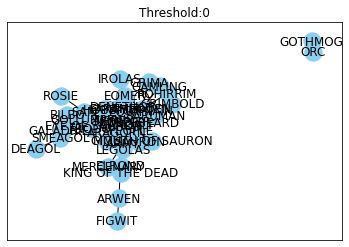

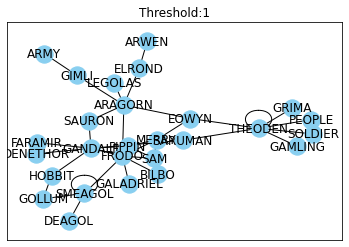

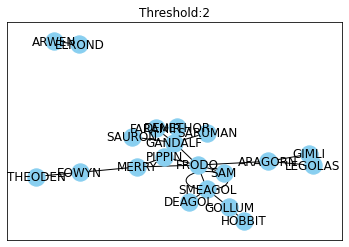

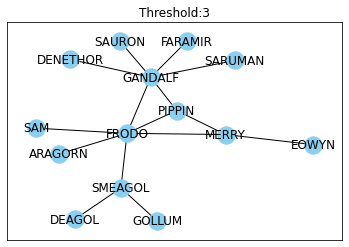

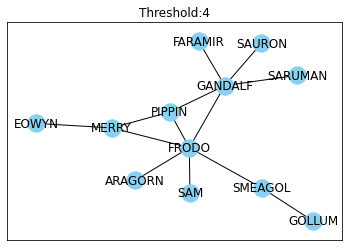

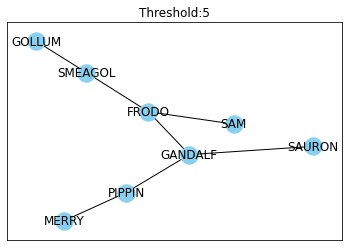

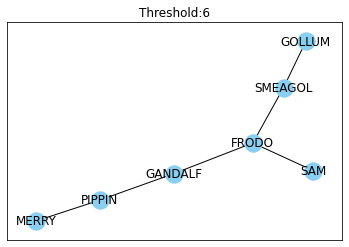

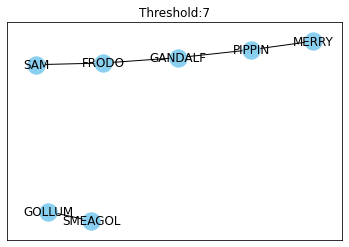

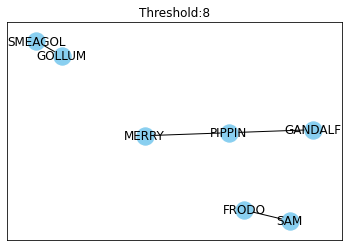

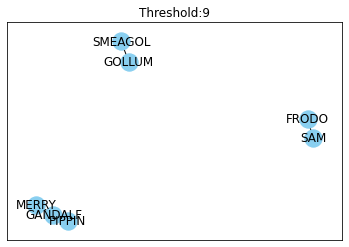

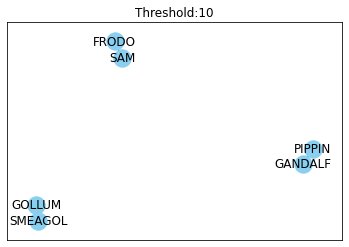

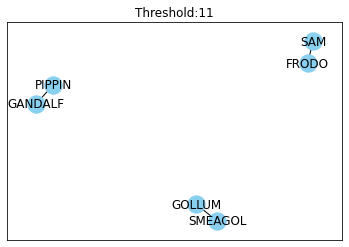

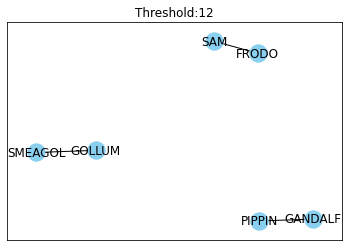

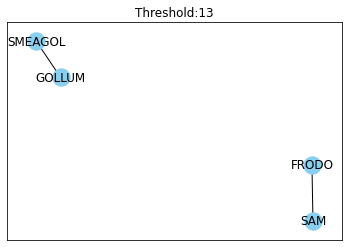

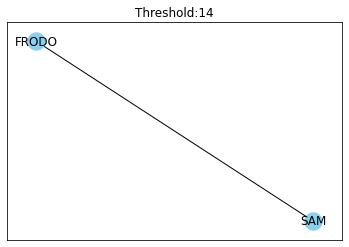

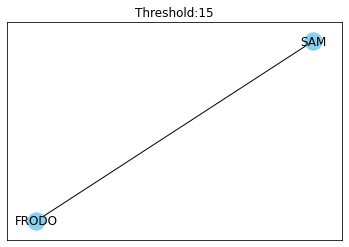

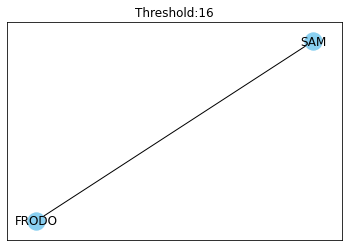

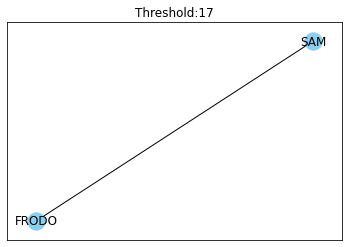

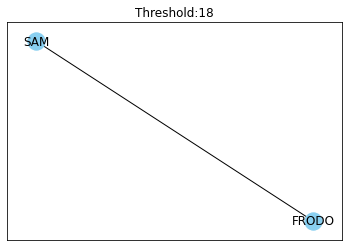

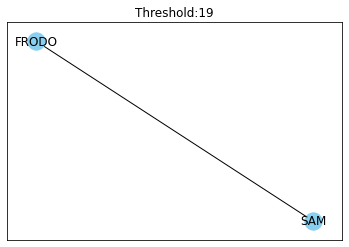

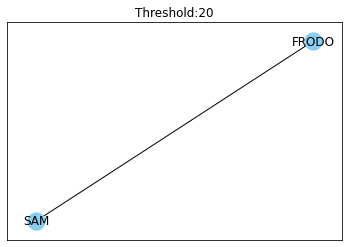

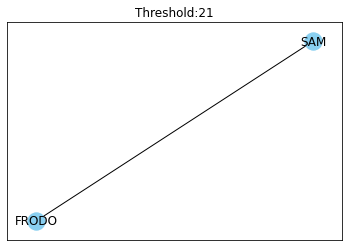

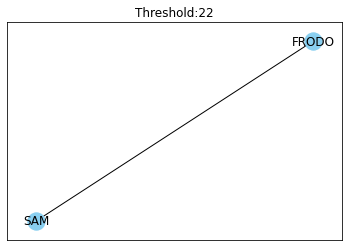

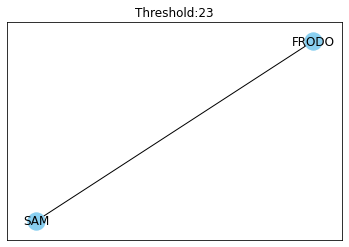

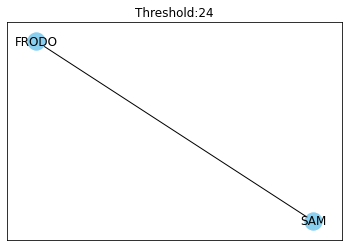

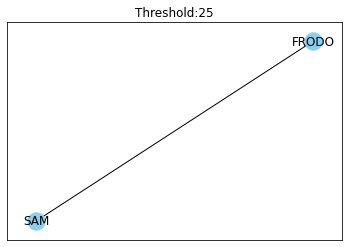

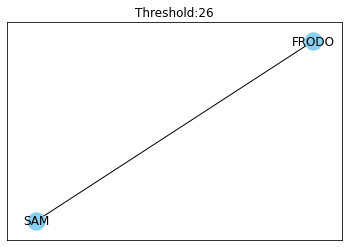

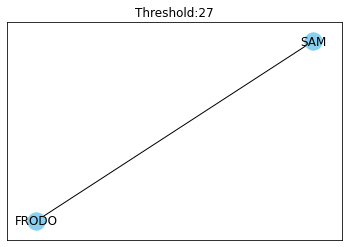

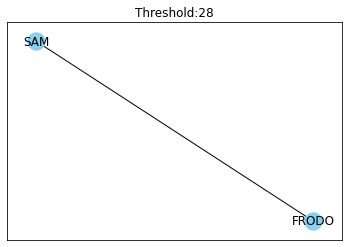

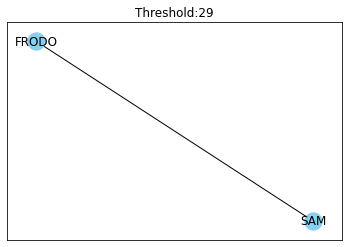

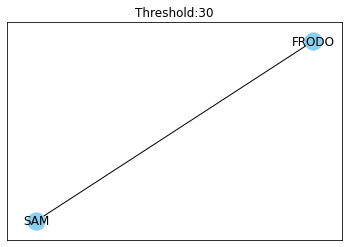

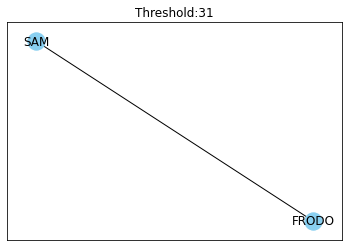

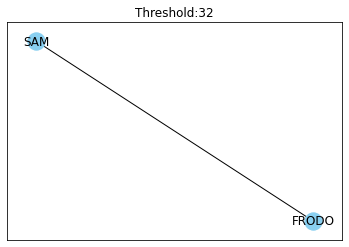

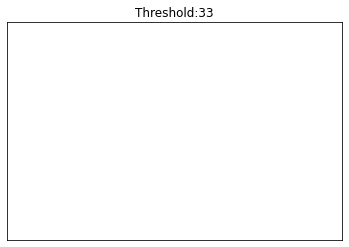

In [379]:
for i in range(34):
    get_relationships(fellowship_df, fellowship_df.char.unique().tolist(), i)

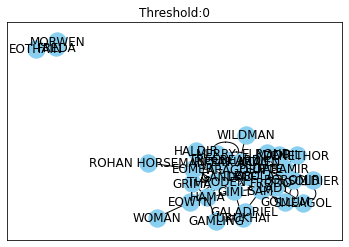

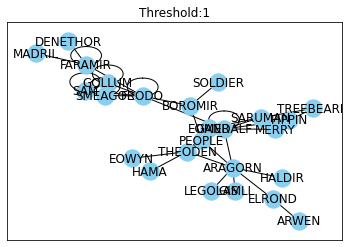

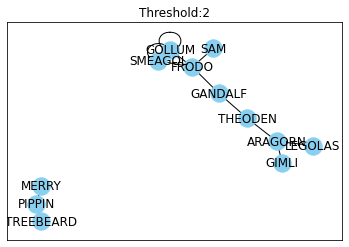

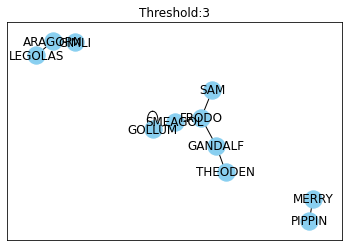

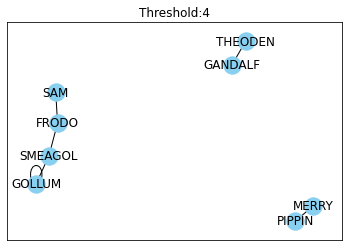

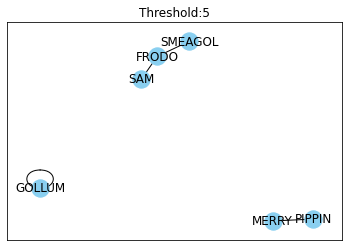

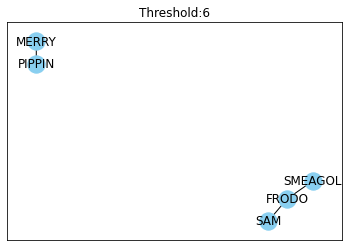

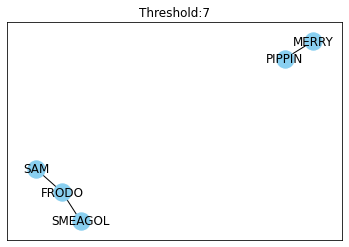

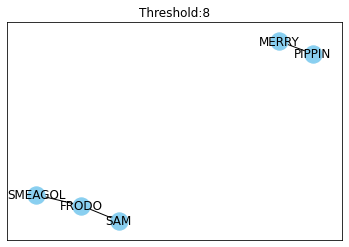

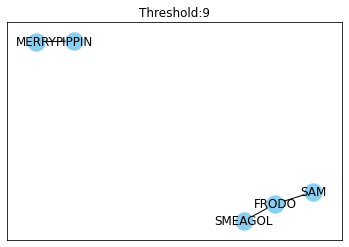

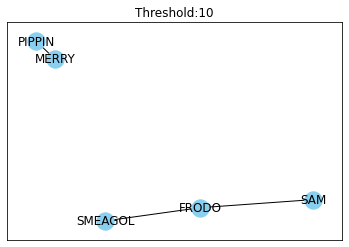

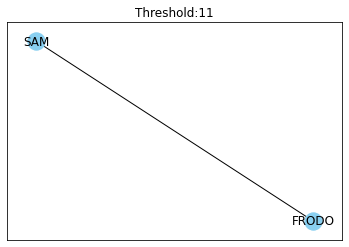

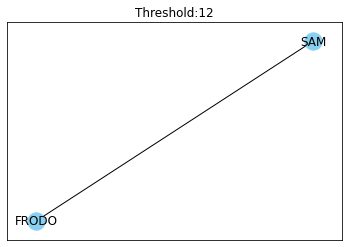

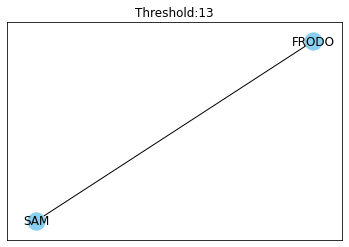

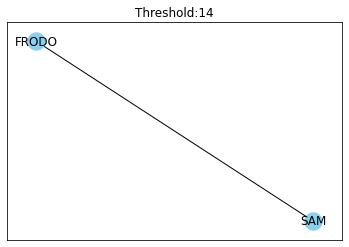

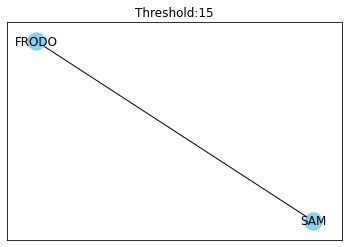

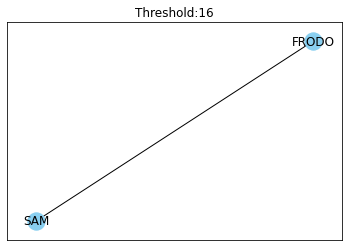

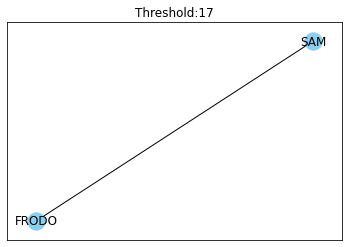

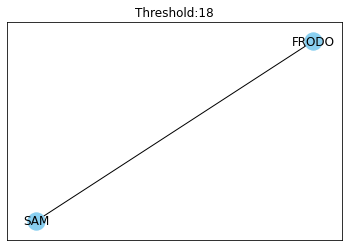

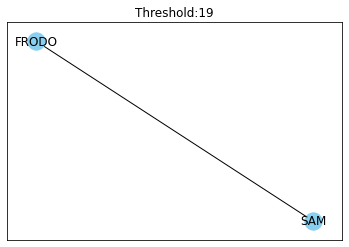

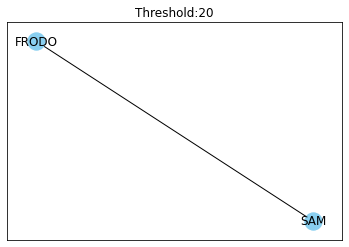

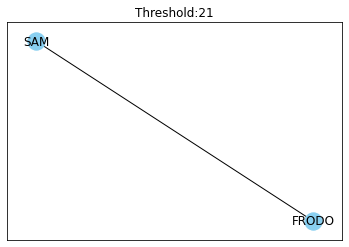

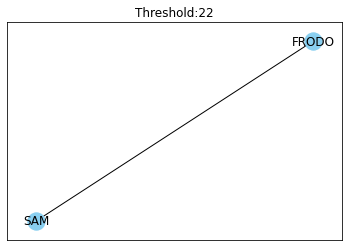

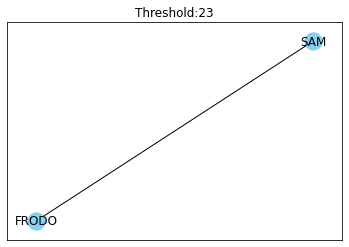

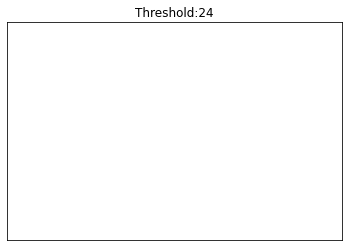

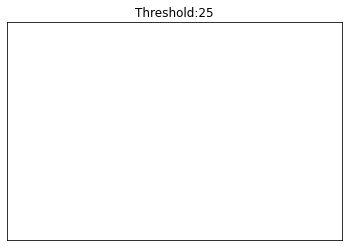

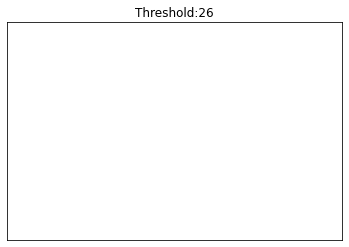

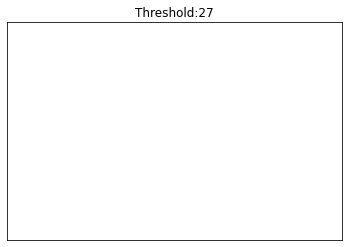

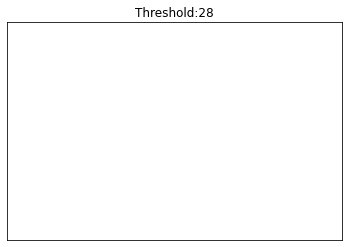

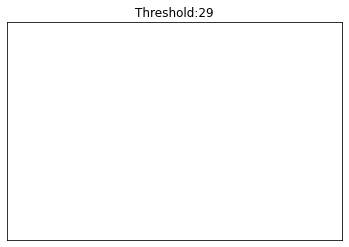

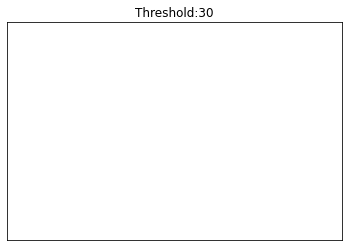

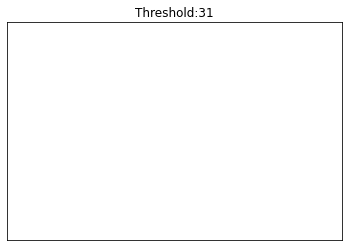

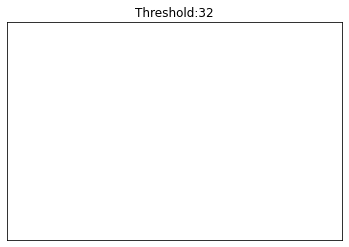

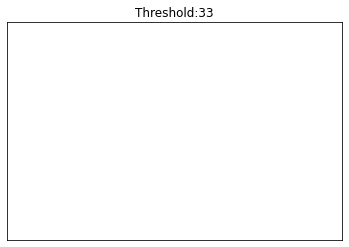

In [380]:
for i in range(34):
    get_relationships(two_towers_df, two_towers_df.char.unique().tolist(), i)

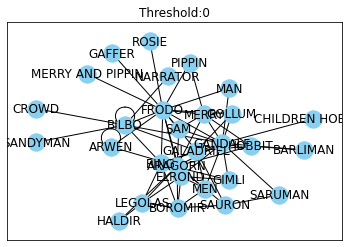

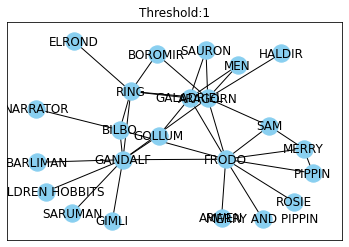

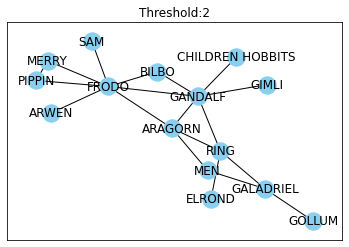

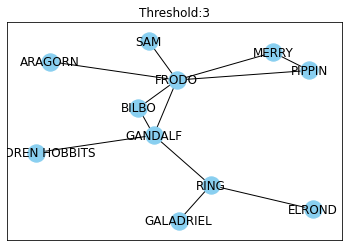

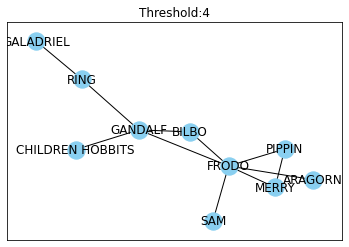

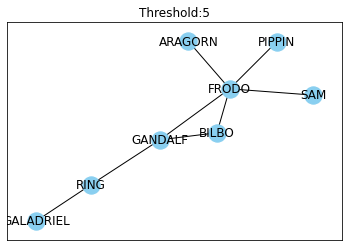

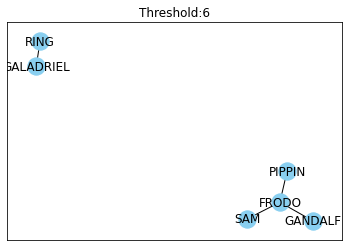

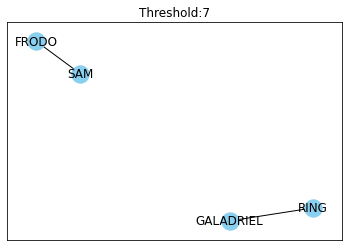

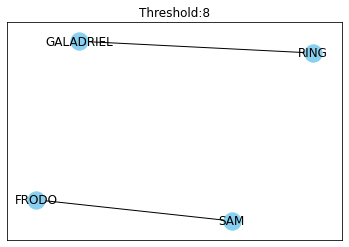

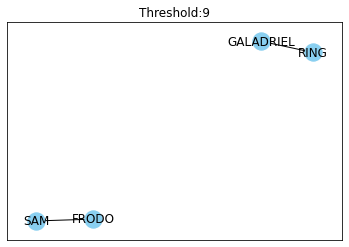

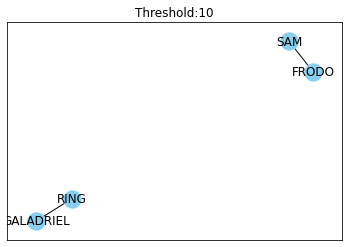

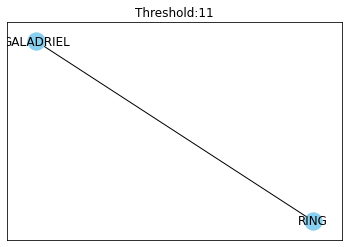

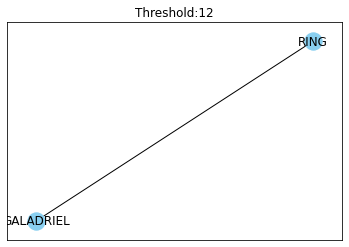

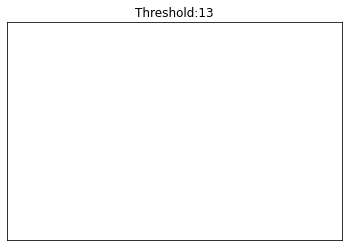

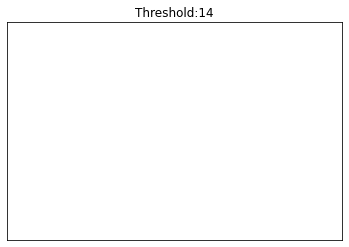

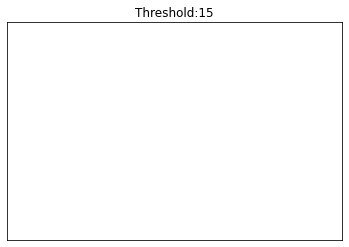

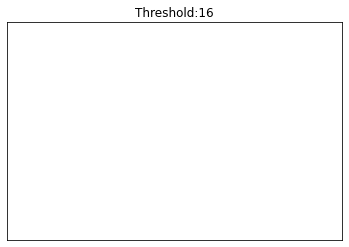

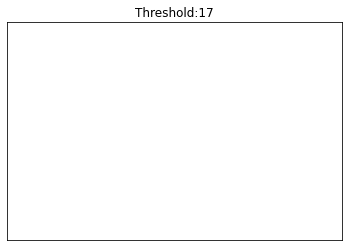

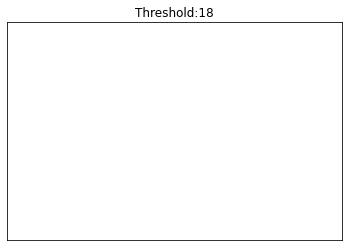

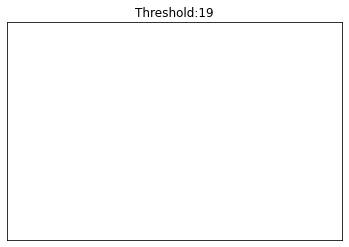

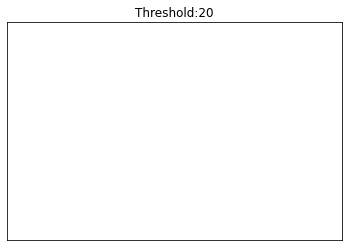

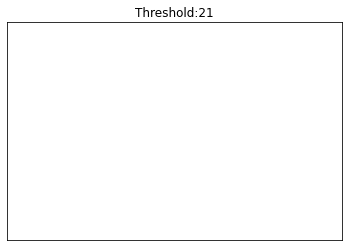

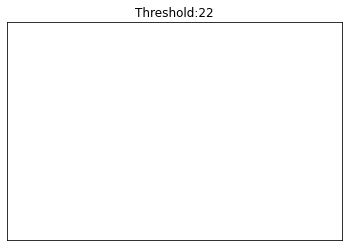

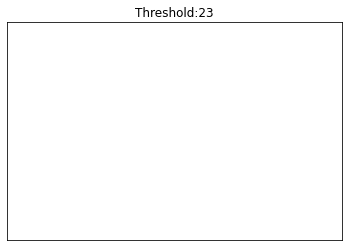

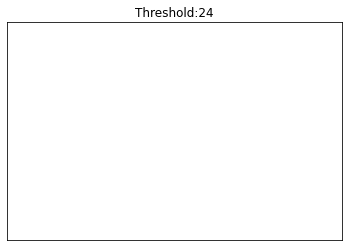

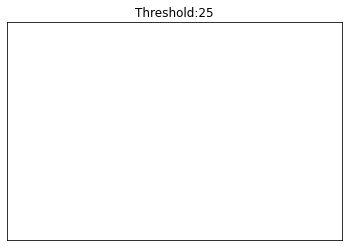

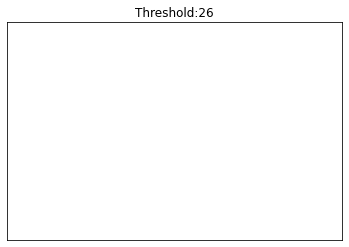

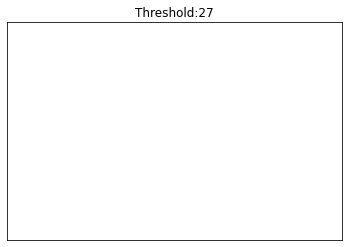

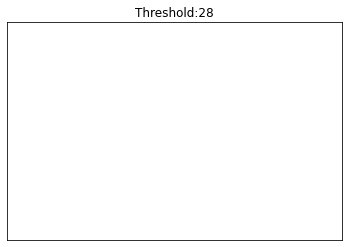

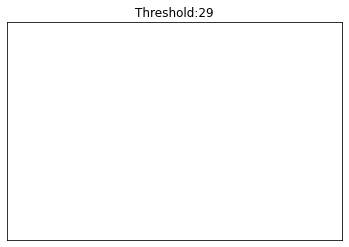

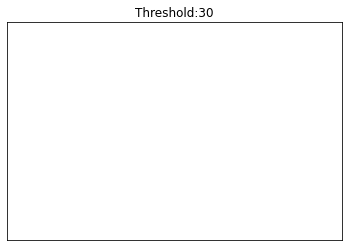

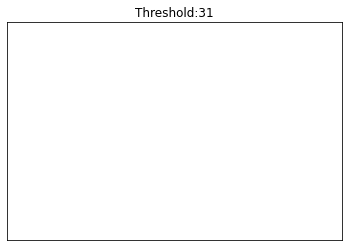

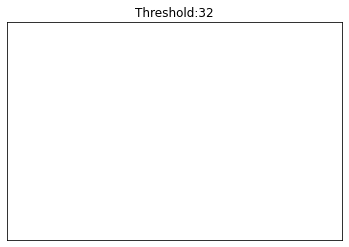

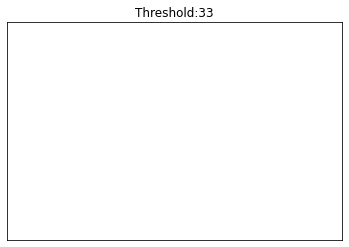

In [381]:
for i in range(34):
    get_relationships(return_king_df, return_king_df.char.unique().tolist(), i)

# Now let us try to see if there was any character growth for the top 10 characters

In [385]:
def get_char_growth(df_list, char):
    
    for df in df_list:
        # Get char vocabulary
        char_vocab = consolidate_char_vocab(df, char)
        top5_words = sorted(char_vocab, key=char_vocab.get, reverse=True)[:5]



        subset = {key: char_vocab[key] for key in top5_words}
        names = list(subset.keys())
        values = list(subset.values())
        plt.title(f'Frequency of words for {char} in the movie: {df.movie.unique()[0]}' )
        plt.bar(range(len(subset)), values, tick_label=names)
        plt.show()
        
    
    

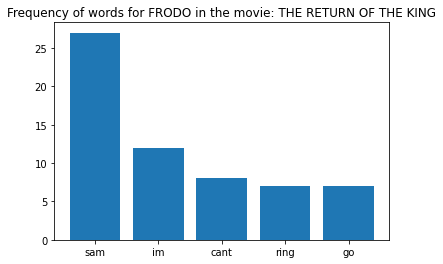

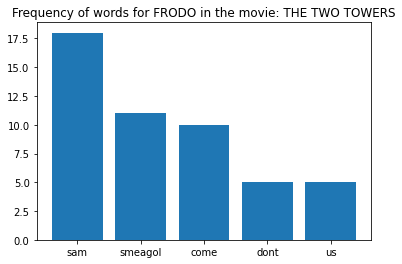

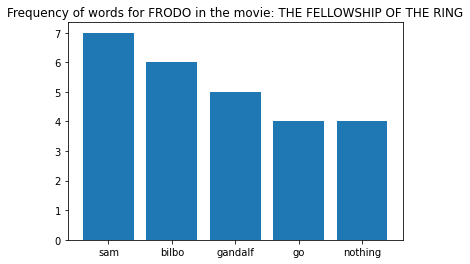

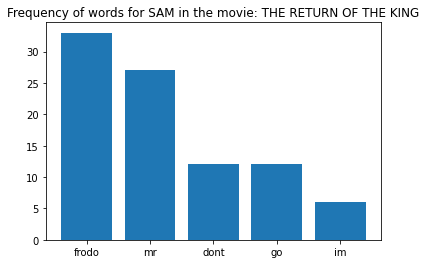

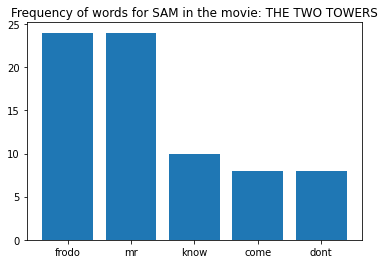

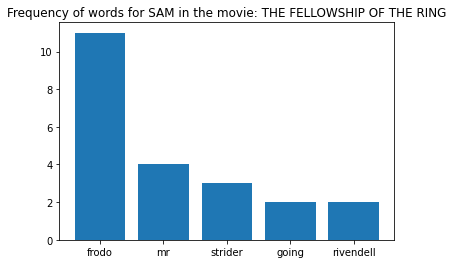

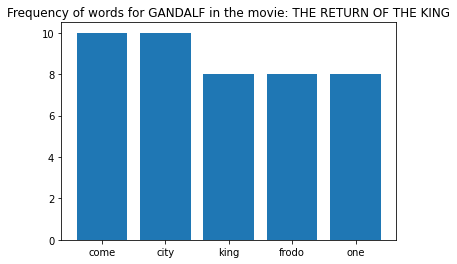

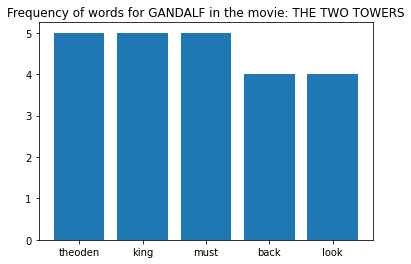

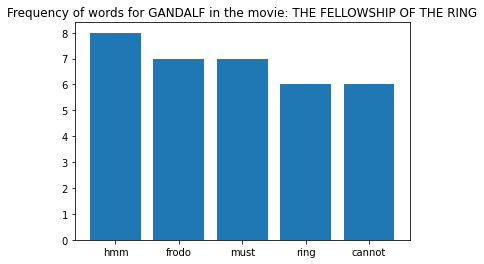

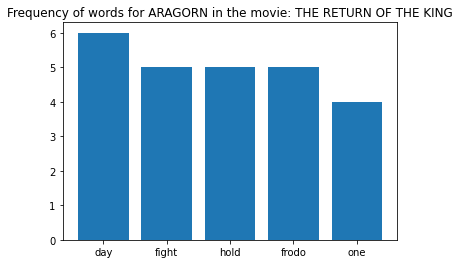

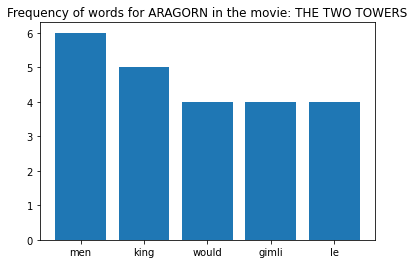

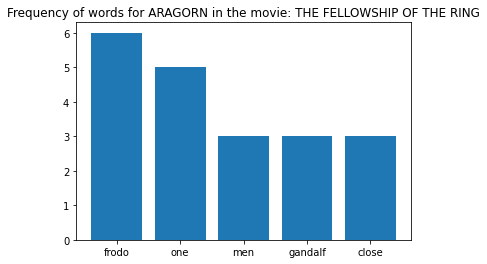

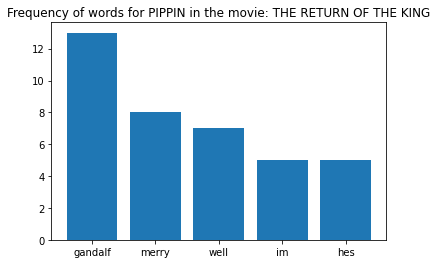

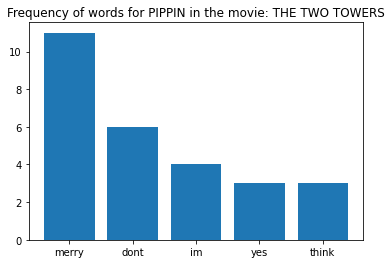

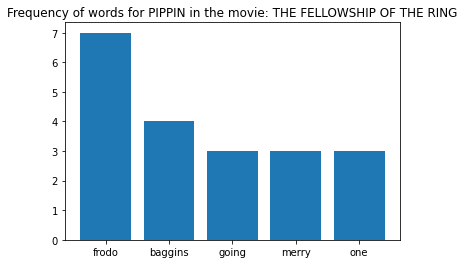

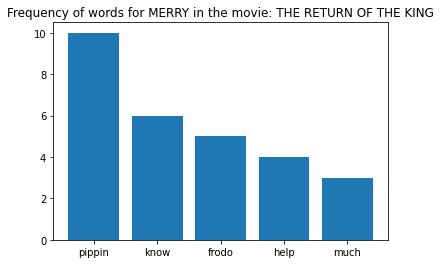

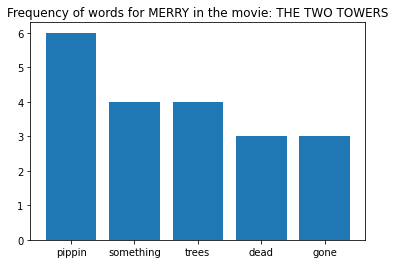

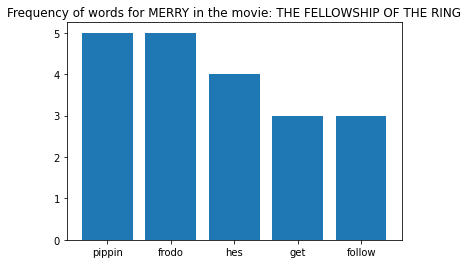

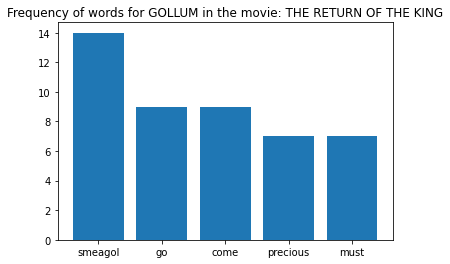

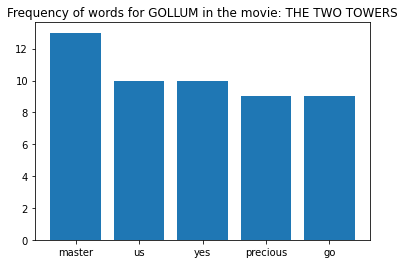

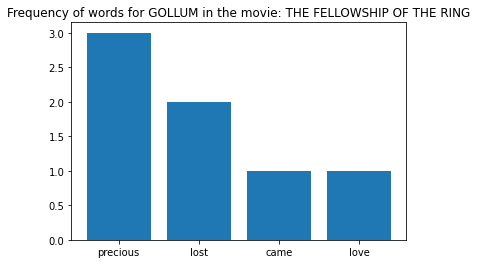

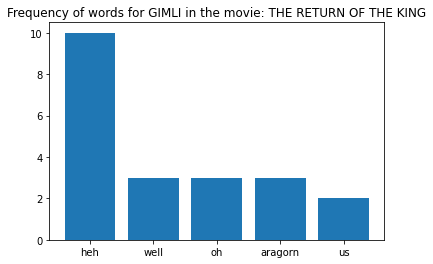

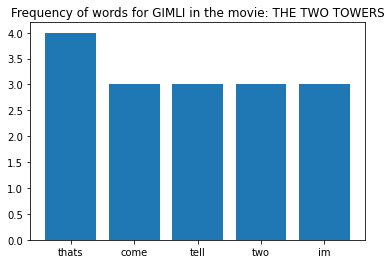

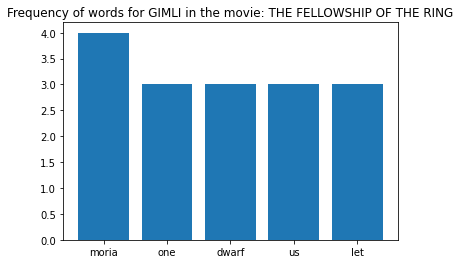

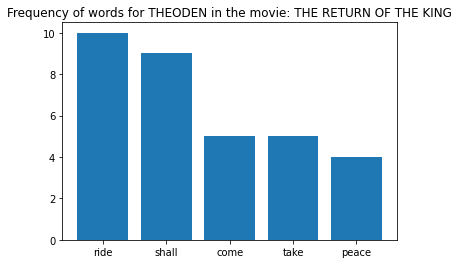

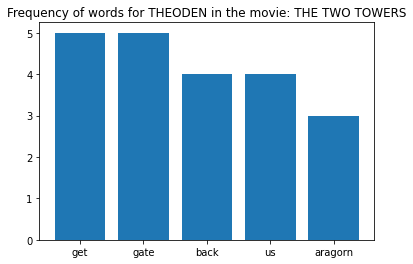

IndexError: list index out of range

In [387]:
for char in top10_chars_allmovies:
    get_char_growth([fellowship_df,two_towers_df, return_king_df], char)

In [152]:
dict_of_char_vocabs

{'FRODO': Counter({'gandalf': 2,
          'oooohhh': 1,
          'gimli': 1,
          'isnt': 2,
          'midday': 1,
          'yet': 1,
          'days': 1,
          'growing': 1,
          'darker': 1,
          'sam': 27,
          'aragorn': 1,
          'thus': 1,
          'fourth': 1,
          'age': 1,
          'middle': 2,
          'earth': 2,
          'began': 1,
          'fellowship': 1,
          'ring': 7,
          'though': 1,
          'eternally': 1,
          'bound': 1,
          'friendship': 1,
          'love': 1,
          'ended': 1,
          'thirteen': 1,
          'months': 1,
          'day': 2,
          'since': 2,
          'sent': 1,
          'us': 2,
          'long': 2,
          'journey': 2,
          'find': 1,
          'looking': 1,
          'upon': 1,
          'familiar': 1,
          'sight': 1,
          'home': 2,
          'pick': 1,
          'threads': 1,
          'old': 1,
          'life': 1,
          'go': 7,
          

In [391]:
colors = ['green', 'maroon', 'teal', 'indigo', 'limegreen', 
          'mediumblue', 'fuchsia', 'cyan', 'coral', 'seagreen']

*Results so far: In the first and third movies, Gandalf has the most lines of any character. He is noticably missing from the second movie because he fell into a pit with the Balrog. Now we will join our data with the characters dataframe to try to find additional insights*

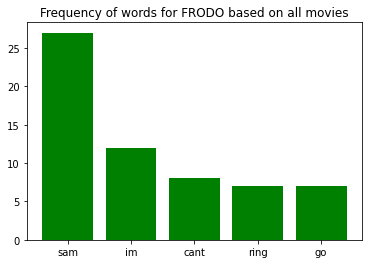

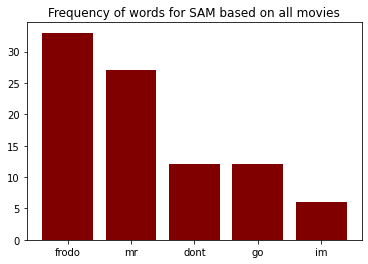

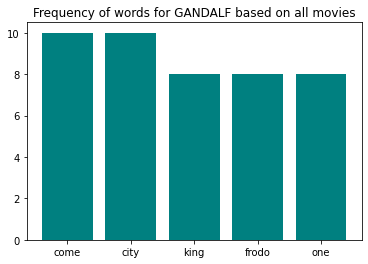

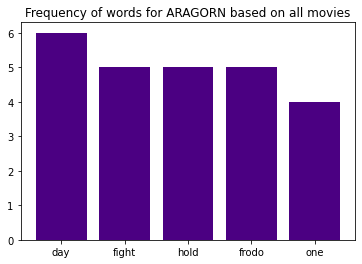

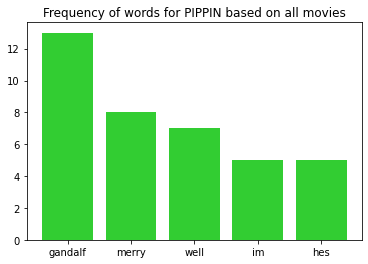

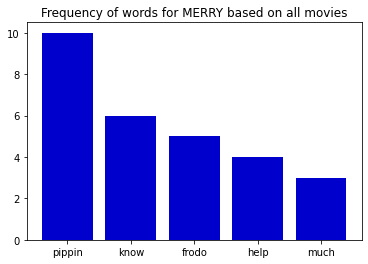

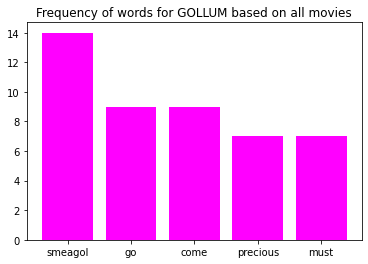

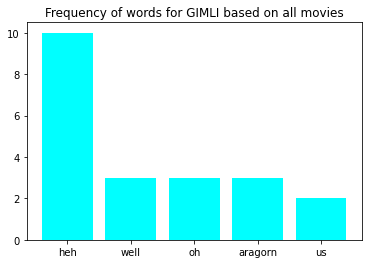

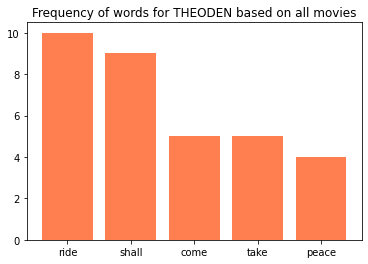

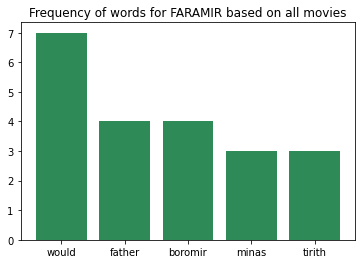

In [392]:
i = 0
for char in dict_of_char_vocabs:
    
    data = dict_of_char_vocabs[char]
    top5_words = sorted(data, key=data.get, reverse=True)[:5]



    subset = {key: data[key] for key in top5_words}
    names = list(subset.keys())
    values = list(subset.values())
    plt.title('Frequency of words for ' + char + ' based on all movies')
    plt.bar(range(len(subset)), values, tick_label=names, color=colors[i])
    i += 1
    plt.show()

